In [2]:
%load_ext autoreload
%autoreload 2

from cnn import CNN
from dyn_cnn import DynCNN
from util import Util
from patch import Patch
from fixer import Fixer
from uglify import Uglify

import cPickle as pickle
import os
import mahotas as mh
import numpy as np
import time

import mlproof as mlp


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
tifffile.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [40]:
image, prob, mask, gold, rhoana = mlp.Util.read_section('/home/d/data/cylinder/', 250)

Loading z00000250.png


In [9]:
Util.vi(gold, rhoana)

0.37294998439310856

In [3]:
with open('/home/d/nets/MergeNet_larger_border_overlap_cylinder1_dataaugmentation/net.p', 'rb') as f:
    cnn = pickle.load(f)

In [25]:
with open('/home/d/nets/MergeNet_cylinder1_larger_border_overlap_usevars/net.p', 'rb') as f:
    cnn = pickle.load(f)

In [10]:
vi_s, merge_pairs, surenesses = Fixer.splits(cnn,image, prob, rhoana, gold, 
                                                 sureness_threshold=.95,
                                                 verbose=True)

6252 generated in 376.84928298 seconds.
Grouped into 1533 patches in 0.027116060257 seconds.
Merge loop finished in 366.978486061 seconds.
Before VI: 0.372949984393
Smallest VI: 0.344331472155
Sureness threshold: 0.975017488003


In [13]:
from uitools import UITools

In [41]:
merge_errors = get_merge_errors(cnn, image, prob, rhoana)

KeyboardInterrupt: 

In [16]:
def get_merge_errors(cnn, input_image, input_prob, input_rhoana):
    #
    # this creates the top bins for the best five merge splits but also simulates the user who picks the best
    #
    #
    t0 = time.time()
    fixed_volume = np.array(input_rhoana)

    merge_errors = []
        
    hist = Util.get_histogram(input_rhoana.astype(np.uint64))
    labels = range(len(hist))

    fixed_slice = np.array(input_rhoana, dtype=np.uint64)

    for l in labels:

        if l == 0 or hist[l]<3000:
            continue

        # single binary mask for label l
        before_merge_error = np.zeros(input_rhoana.shape)
        before_merge_error[fixed_slice == l] = 1

        results = Fixer.fix_single_merge(cnn,
                                          input_image,
                                          input_prob,
                                          before_merge_error, N=50, 
                                          erode=True, 
                                          invert=True,
                                          dilate=True,
                                          border_seeds=True,
                                          oversampling=False)

        if len(results) > 0:

            #
            # SORT THE PREDICTIONS (prediction, border)-tupels
            # LOOK AT TOP 5
            sorted_pred = sorted(results, key=lambda x: x[0])

            top5 = sorted_pred[:5]

            lowest_prediction = sorted_pred[0][0]


            # store the merge error
            # we need to store: z, l, results_no_border, borders, predictions
            merge_errors.append((0, l, lowest_prediction, (top5)))
                
    if verbose:
      print 'merge error correction done after',time.time()-t0, 'seconds'

    return merge_errors

In [20]:
before_vi_s = []
cylinder_vi_s = []
vi_diffs = []
m_s = []
for z in range(250, 300):
    image, prob, mask, gold, rhoana = mlp.Util.read_section('/home/d/data/cylinder/', z)
    before_vi_s.append(Util.vi(gold, rhoana))
    vi_s, merge_pairs, surenesses, m = Fixer.splits(cnn,image, prob, rhoana, gold, 
                                                     sureness_threshold=.95,
                                                     verbose=True)
    m_s.append(m)
    cylinder_vi_s.append(vi_s[-1])
    vi_diffs.append(before_vi_s[-1]-cylinder_vi_s[-1])

Loading z00000250.png
6252 generated in 386.685360909 seconds.
Grouped into 1533 patches in 0.0252959728241 seconds.
Merge loop finished in 371.824840069 seconds.
Before VI: 0.372949984393
Smallest VI: 0.344331472155
Sureness threshold: 0.975017488003
Loading z00000251.png
5820 generated in 357.727037907 seconds.
Grouped into 1422 patches in 0.0253109931946 seconds.
Merge loop finished in 348.276534081 seconds.
Before VI: 0.375702196618
Smallest VI: 0.343974283504
Sureness threshold: 0.999323785305
Loading z00000252.png
6368 generated in 396.131755829 seconds.
Grouped into 1572 patches in 0.0281329154968 seconds.
Merge loop finished in 373.461359978 seconds.
Before VI: 0.410965843839
Smallest VI: 0.36383302442
Sureness threshold: 0.989225804806
Loading z00000253.png
5692 generated in 349.935687065 seconds.
Grouped into 1402 patches in 0.0252420902252 seconds.
Merge loop finished in 362.181889057 seconds.
Before VI: 0.373934285105
Smallest VI: 0.338268001883
Sureness threshold: 0.991696

ValueError: zero-size array to reduction operation minimum which has no identity

In [33]:
range(int(np.inf))

OverflowError: cannot convert float infinity to integer

In [22]:
vi_diffs

[0.02850410016100291,
 0.026289098543847977,
 0.04243903505271085,
 0.02135359013679672,
 0.01788756281585613,
 0.0257723099447853,
 0.03040667797289487,
 0.026439906495457244,
 0.02527577840942552,
 0.03613829031001892,
 0.03773676193759101,
 0.025346801262703167,
 0.049446594838946645,
 0.02602956391112432,
 0.05444383674350739,
 0.012760932746043174,
 0.05841365165065593,
 0.04231655233927967,
 0.06756138542628953,
 0.044623348293738374,
 0.05717483029639947,
 0.06218477911427556,
 0.06358717938983727,
 0.02988200089841797,
 0.028029913104062665,
 0.09205238607098387,
 0.09028762887742481,
 0.02937349489634844,
 0.05321581456959734,
 0.089790295851218,
 0.07728348427360565,
 0.04089020542771227,
 0.008404536527030437,
 0.06656378165668553,
 0.07090021651908529,
 0.05923234243461284,
 0.044567798165193295,
 0.07257880750171264,
 0.08816872025487399,
 0.05776560365426864,
 0.041860687197528,
 0.013331368105869323,
 0.03483523119726062,
 0.024997898933218465,
 0.010620413362377512,
 0.

In [38]:
np.mean(before_vi_s)

0.47479850263762785

In [39]:
np.mean(cylinder_vi_s)

0.43048052560018774

In [25]:
before_vi_s

[0.37294998439310856,
 0.37570219661839666,
 0.4109658438387207,
 0.37393428510508553,
 0.3762287531092978,
 0.37385760820585645,
 0.4014037597672475,
 0.4554609382482129,
 0.44628578370391203,
 0.6030340271019625,
 0.6163519590275044,
 0.6087015023726021,
 0.5919024759227103,
 0.5605457129847213,
 0.5705925664914542,
 0.5952651035175354,
 0.5795615981375537,
 0.5594166501537927,
 0.49946323720437213,
 0.44618979740162246,
 0.4548631943347914,
 0.42050231396302173,
 0.4385921810227087,
 0.4705584345378737,
 0.4330805382494942,
 0.527164362396328,
 0.4988453695588202,
 0.5251819097450561,
 0.5307623709392573,
 0.5755674642935071,
 0.5496714227025956,
 0.4308503204354386,
 0.5024395754252415,
 0.4989349104857448,
 0.5461621705031456,
 0.48507618715427103,
 0.4800801727583428,
 0.5620959866608635,
 0.6353546903196463,
 0.5627896696766568,
 0.5247327438711675,
 0.5266254947401299,
 0.46047548986476716,
 0.48441914645616,
 0.4524912015296758,
 0.4118202313464083,
 0.40229724602881056,
 0.32

In [29]:
len(m_s)

48

In [32]:
m_s[298-250]

IndexError: list index out of range

In [28]:
range(299,300)

[299]

In [34]:
# for z in range(298, 300):
z=298
image, prob, mask, gold, rhoana = mlp.Util.read_section('/home/d/data/cylinder/', z)
#     before_vi_s.append(Util.vi(gold, rhoana))
vi_s, merge_pairs, surenesses, m = Fixer.splits(cnn,image, prob, rhoana, gold, 
                                                 sureness_threshold=.95,
                                                 verbose=True)
# m_s.append(m)
if len(vi_s) > 0:
    cylinder_vi_s.append(vi_s[-1])
    vi_diffs.append(before_vi_s[-1]-cylinder_vi_s[-1])
else:
    cylinder_vi_s.append(0)
    vi_diffs.append(before_vi_s[-1])

z=299
image, prob, mask, gold, rhoana = mlp.Util.read_section('/home/d/data/cylinder/', z)
before_vi_s.append(Util.vi(gold, rhoana))
vi_s, merge_pairs, surenesses, m = Fixer.splits(cnn,image, prob, rhoana, gold, 
                                                 sureness_threshold=.95,
                                                 verbose=True)
m_s.append(m)
if len(vi_s) > 0:
    cylinder_vi_s.append(vi_s[-1])
    vi_diffs.append(before_vi_s[-1]-cylinder_vi_s[-1])
else:
    cylinder_vi_s.append(0)
    vi_diffs.append(before_vi_s[-1])

Loading z00000298.png
4 generated in 4.69571900368 seconds.
Grouped into 1 patches in 6.29425048828e-05 seconds.
Merge loop finished in 0.000369071960449 seconds.
Loading z00000299.png
0 generated in 0.0278921127319 seconds.
Grouped into 0 patches in 2.90870666504e-05 seconds.
Merge loop finished in 7.5101852417e-05 seconds.


In [37]:
len(vi_diffs)

50

In [46]:
#with open('/home/d/dojo_xp/data/bigM_cylinder_250_300.p', 'wb') as f:
#    pickle.dump(m_s, f)

In [7]:
with open('/home/d/dojo_xp/data/bigM_cylinder_250_300.p', 'rb') as f:
    m_s = pickle.load(f)

In [4]:
#
# now automated user
#

# load data as volume
volume = []
volume_prob = []
volume_segmentation = []
volume_groundtruth = []
for z in range(250, 300):
    image, prob, mask, gold, rhoana = mlp.Util.read_section('/home/d/data/cylinder/', z)
    
    volume.append(image)
    volume_prob.append(prob)
    volume_segmentation.append(rhoana)
    volume_groundtruth.append(gold)
    

Loading z00000250.png
Loading z00000251.png
Loading z00000252.png
Loading z00000253.png
Loading z00000254.png
Loading z00000255.png
Loading z00000256.png
Loading z00000257.png
Loading z00000258.png
Loading z00000259.png
Loading z00000260.png
Loading z00000261.png
Loading z00000262.png
Loading z00000263.png
Loading z00000264.png
Loading z00000265.png
Loading z00000266.png
Loading z00000267.png
Loading z00000268.png
Loading z00000269.png
Loading z00000270.png
Loading z00000271.png
Loading z00000272.png
Loading z00000273.png
Loading z00000274.png
Loading z00000275.png
Loading z00000276.png
Loading z00000277.png
Loading z00000278.png
Loading z00000279.png
Loading z00000280.png
Loading z00000281.png
Loading z00000282.png
Loading z00000283.png
Loading z00000284.png
Loading z00000285.png
Loading z00000286.png
Loading z00000287.png
Loading z00000288.png
Loading z00000289.png
Loading z00000290.png
Loading z00000291.png
Loading z00000292.png
Loading z00000293.png
Loading z00000294.png
Loading z0

In [5]:
from fixer import Fixer

In [53]:
new_m_s, out_volume = Fixer.splits_global_from_M(cnn, m_s, 
                                                 volume, 
                                                 volume_prob, 
                                                 volume_segmentation, 
                                                 volume_groundtruth)

In [55]:
sim_user_vi_s = []
for ov in range(out_volume.shape[0]):
    vi = Util.vi(volume_groundtruth[ov], out_volume[ov])
    sim_user_vi_s.append(vi)

In [56]:
# after 30 mins
sim_user_vi_s

[0.37095217382355017,
 0.3734009898741375,
 0.40756873869895305,
 0.36776293625678225,
 0.3759834540484803,
 0.36779124780368466,
 0.39890467701099386,
 0.44844350571188496,
 0.4411967077891239,
 0.5957326383015307,
 0.5983145793575186,
 0.5887364325510518,
 0.5870299736616058,
 0.5454769197467524,
 0.5559007504749971,
 0.5923274528974289,
 0.5745816204774492,
 0.5497092357749018,
 0.4903541068341237,
 0.42528595211914144,
 0.4472384041936559,
 0.41224751668111814,
 0.43123033115152243,
 0.46293089005168664,
 0.4257582952779231,
 0.5157003059771554,
 0.49187802408204373,
 0.5184656997008625,
 0.5246791784860658,
 0.568430062470128,
 0.5414983408994152,
 0.425745730148952,
 0.4827125246880817,
 0.4989349104857448,
 0.517663437152776,
 0.4850150106665705,
 0.4768313747399908,
 0.5620959866608635,
 0.6334247185851591,
 0.5609270233049877,
 0.516790775720585,
 0.5266254947401299,
 0.46047548986476716,
 0.4792217602676221,
 0.44601155604026843,
 0.4118202313464083,
 0.40229724602881056,
 0.

In [19]:
new_m_s, out_volume, fixes, vi_s30mins = Fixer.splits_global_from_M(cnn, m_s, 
                                                 volume, 
                                                 volume_prob, 
                                                 volume_segmentation, 
                                                 volume_groundtruth)

In [23]:
13./len(fixes)

0.21666666666666667

In [26]:
fixes

['Good',
 'Good',
 'Good',
 'Good',
 'Bad',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Bad',
 'Bad',
 'Bad',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Bad',
 'Good',
 'Good',
 'Bad',
 'Good',
 'Bad',
 'Good',
 'Good',
 'Bad',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Bad',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Bad',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Bad',
 'Good',
 'Good',
 'Good',
 'Bad',
 'Bad',
 'Good',
 'Good',
 'Good',
 'Good']

In [69]:
len(fixes)

17280

In [71]:
vi_s30mins[-1]

[0.3126860168690291,
 0.3176697482932056,
 0.3302104193741373,
 0.31483383687785604,
 0.31210496689256306,
 0.32538244666561766,
 0.33962959140397153,
 0.39714131759305005,
 0.3624404880151362,
 0.5284855112358224,
 0.5075131931806709,
 0.5115734091636099,
 0.5103020463891603,
 0.4977703109749534,
 0.4926450576369614,
 0.5049320666380162,
 0.4969231222214763,
 0.46218377125609234,
 0.40691808196112866,
 0.32553562981665163,
 0.36505942450307316,
 0.3391962828418027,
 0.3521595516324689,
 0.38656325250959167,
 0.3482572675026949,
 0.4131306750112005,
 0.39317896321270407,
 0.42250609975853504,
 0.4373989149095605,
 0.44620685433280105,
 0.43926308338379894,
 0.36321083244825303,
 0.43123766723319257,
 0.41274221676600753,
 0.4562503567596403,
 0.3896619840792157,
 0.4374606477905001,
 0.4504661699145842,
 0.5297067759929899,
 0.49245128232290813,
 0.4593740616109674,
 0.4471210637864287,
 0.4142923323784977,
 0.4638166258738714,
 0.4284947674868276,
 0.3979622656067985,
 0.3876253540702

In [72]:
vi_s30mins[0]

[0.37294998439310856,
 0.37570219661839666,
 0.4109658438387207,
 0.37393428510508553,
 0.3762287531092978,
 0.37385760820585645,
 0.4014037597672475,
 0.4554609382482129,
 0.44628578370391203,
 0.6030340271019625,
 0.6163519590275044,
 0.6087015023726021,
 0.5919024759227103,
 0.5603822365533073,
 0.5705925664914542,
 0.5952651035175354,
 0.5795615981375537,
 0.5594166501537927,
 0.49946323720437213,
 0.44618979740162246,
 0.4548631943347914,
 0.42050231396302173,
 0.4385921810227087,
 0.4705584345378737,
 0.4330805382494942,
 0.527164362396328,
 0.4988453695588202,
 0.5251819097450561,
 0.5307623709392573,
 0.5755674642935071,
 0.5496714227025956,
 0.4308503204354386,
 0.5024395754252415,
 0.4989349104857448,
 0.5461621705031456,
 0.48507618715427103,
 0.4800801727583428,
 0.5620959866608635,
 0.6353546903196463,
 0.5627896696766568,
 0.5247327438711675,
 0.5266254947401299,
 0.46047548986476716,
 0.48441914645616,
 0.4524912015296758,
 0.4118202313464083,
 0.40229724602881056,
 0.32

In [81]:
with open('/home/d/dojo_xp/data/vi_s_new_cnn_large.p', 'wb') as f:
    pickle.dump(vi_s30mins, f)

In [82]:
mean_vis_30_mins = []
for vi in vi_s30mins:
    mean_vis_30_mins.append(np.mean(vi))

In [86]:
mean_vis_30_mins[0]

0.47479523310899951

In [90]:
len(fixes)

17280

In [91]:
vi_s30mins[-1]

[0.3126860168690291,
 0.3176697482932056,
 0.3302104193741373,
 0.31483383687785604,
 0.31210496689256306,
 0.32538244666561766,
 0.33962959140397153,
 0.39714131759305005,
 0.3624404880151362,
 0.5284855112358224,
 0.5075131931806709,
 0.5115734091636099,
 0.5103020463891603,
 0.4977703109749534,
 0.4926450576369614,
 0.5049320666380162,
 0.4969231222214763,
 0.46218377125609234,
 0.40691808196112866,
 0.32553562981665163,
 0.36505942450307316,
 0.3391962828418027,
 0.3521595516324689,
 0.38656325250959167,
 0.3482572675026949,
 0.4131306750112005,
 0.39317896321270407,
 0.42250609975853504,
 0.4373989149095605,
 0.44620685433280105,
 0.43926308338379894,
 0.36321083244825303,
 0.43123766723319257,
 0.41274221676600753,
 0.4562503567596403,
 0.3896619840792157,
 0.4374606477905001,
 0.4504661699145842,
 0.5297067759929899,
 0.49245128232290813,
 0.4593740616109674,
 0.4471210637864287,
 0.4142923323784977,
 0.4638166258738714,
 0.4284947674868276,
 0.3979622656067985,
 0.3876253540702

In [92]:
len(mean_vis_30_mins)

17232

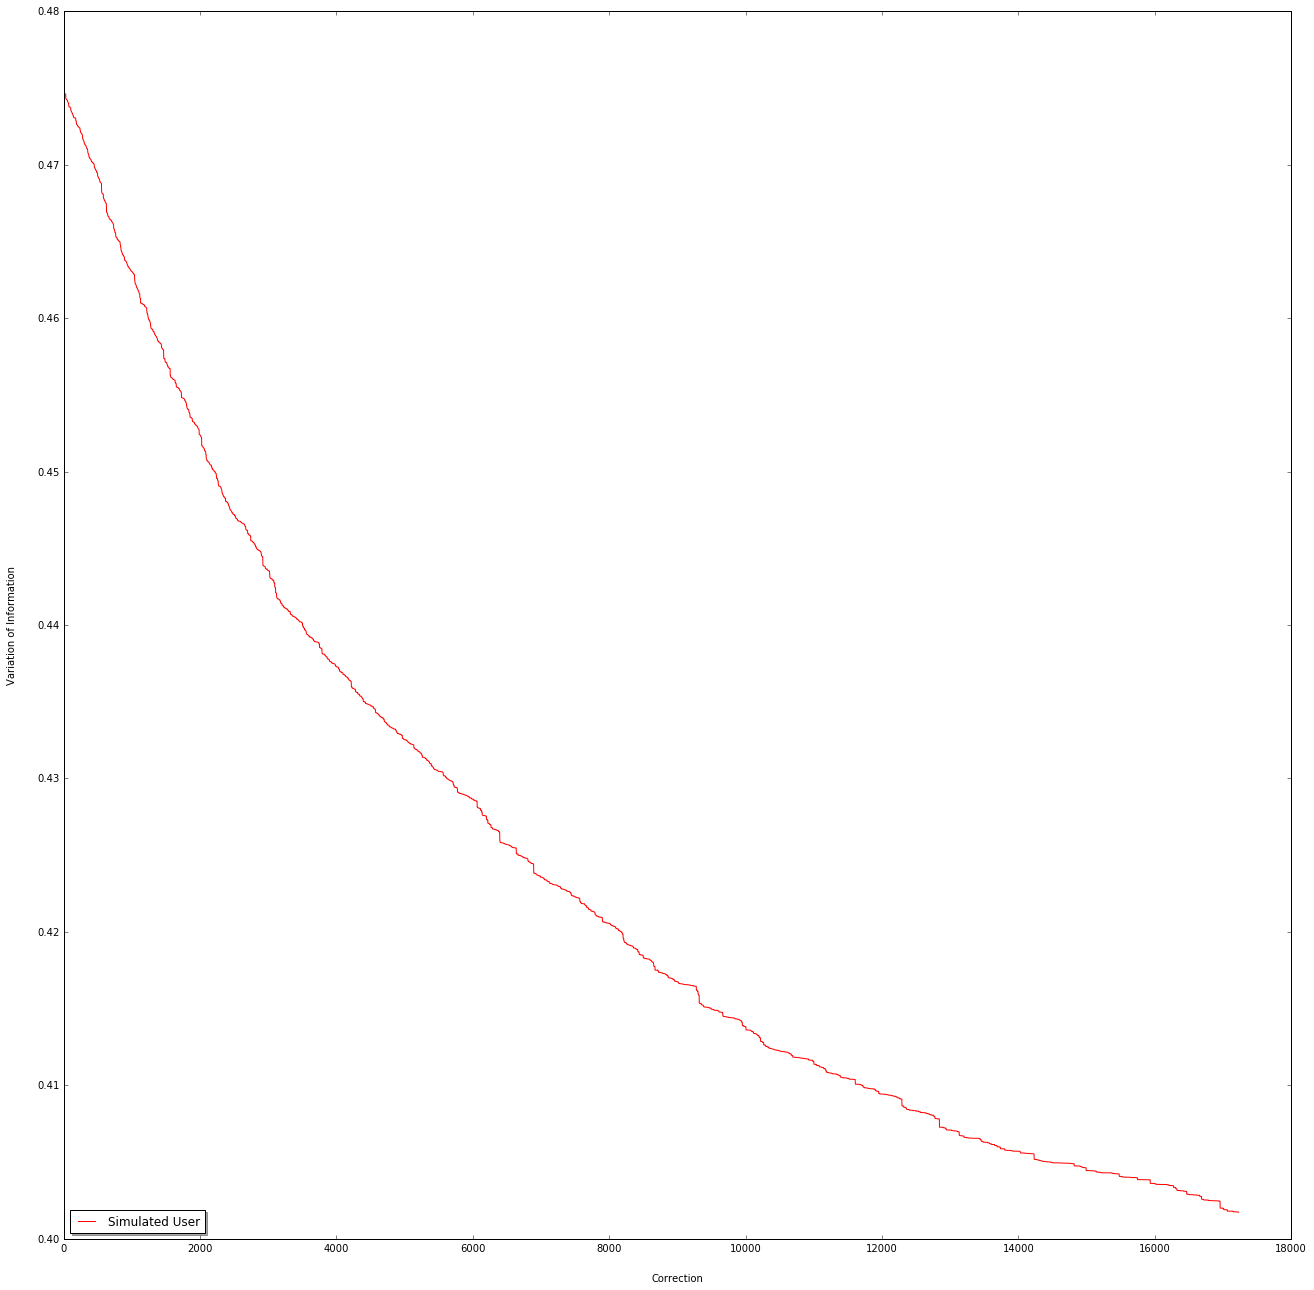

In [95]:
fig, ax = plt.subplots(figsize=(22,22))

x_marks = range(len(mean_vis_30_mins))
ax.plot(x_marks, mean_vis_30_mins, 'r', label='Simulated User')

# # fig, ax = plt.subplots()
# ax.plot(x_marks, old_vi_s, color='b', label='Automatic Corrections (Old CNN)')
# ax.plot(x_marks, new_vi_s, color='g', label='Automatic Corrections (New CNN)')
# ax.plot(x_marks, john_new_vi, color='r')
# ax.plot(x_marks, josh_new_vi, color='b')
plt.ylabel('Variation of Information', labelpad=20)

plt.xlabel('Correction', labelpad=20)

# ax.plot(x_marks, alyssa_new_vi, color='r')
legend = ax.legend(loc='lower left', shadow=True)

# plt.plot()
plt.show()

In [97]:
from collections import Counter

In [101]:
good_fixes_per_minute = []
bad_fixes_per_minute = []
for f in range(0,len(fixes),12):
    counts = Counter(fixes[f:f+12])
    good_counts = counts['Good']
    bad_counts = counts['Bad']
    good_fixes_per_minute.append(good_counts)
    bad_fixes_per_minute.append(bad_counts)

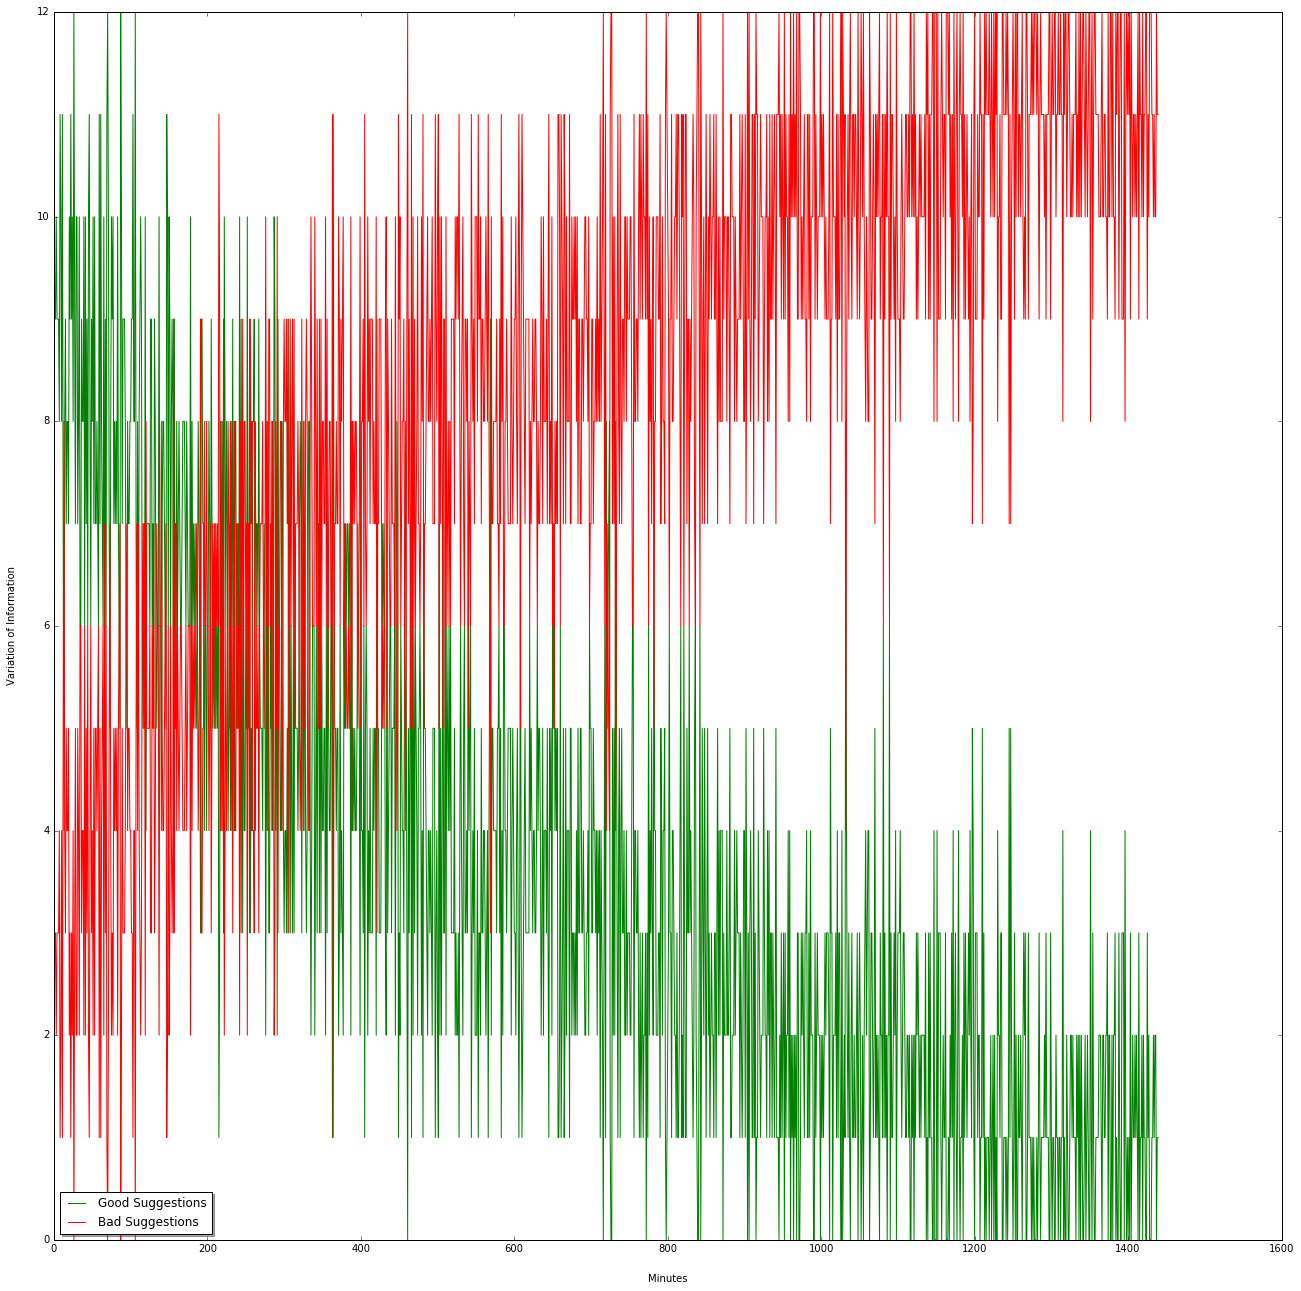

In [108]:
fig, ax = plt.subplots(figsize=(22,22))

x_marks = range(len(good_fixes_per_minute))
ax.plot(x_marks, good_fixes_per_minute, 'g', label='Good Suggestions')
ax.plot(x_marks, bad_fixes_per_minute, 'r', label='Bad Suggestions')

# # fig, ax = plt.subplots()
# ax.plot(x_marks, old_vi_s, color='b', label='Automatic Corrections (Old CNN)')
# ax.plot(x_marks, new_vi_s, color='g', label='Automatic Corrections (New CNN)')
# ax.plot(x_marks, john_new_vi, color='r')
# ax.plot(x_marks, josh_new_vi, color='b')
plt.ylabel('Variation of Information', labelpad=20)

plt.xlabel('Minutes', labelpad=20)

# ax.plot(x_marks, alyssa_new_vi, color='r')
legend = ax.legend(loc='lower left', shadow=True)

# plt.plot()
plt.show()

In [1]:
good_fixes_per_minute

NameError: name 'good_fixes_per_minute' is not defined